In [3]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
import emcee

import utils
import model_spectra as NN
import fitting

import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import corner

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

# Check Autocorrelation Time of MCMC chain for DEIMOS

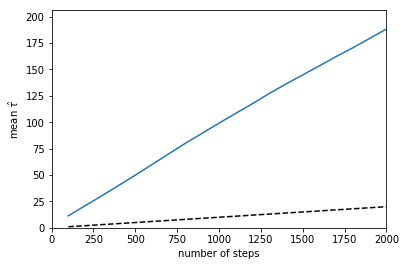

In [98]:
autocorr = np.load('/global/scratch/nathan_sandford/emcee/autocorr.npy')
chain = emcee.backends.HDFBackend('/global/scratch/nathan_sandford/emcee/chain.h5')

n = np.arange(1, len(autocorr) + 1) * 100
y = autocorr
plt.plot(n, n / 100.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1*(y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");

# Check Autocorrelation Time of MCMC chain for Synthetic Training Spectra

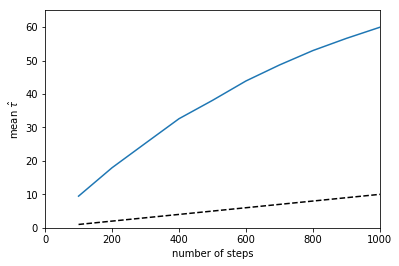

In [101]:
autocorr = np.load('/global/scratch/nathan_sandford/emcee/autocorr_synth.npy')
chain = emcee.backends.HDFBackend('/global/scratch/nathan_sandford/emcee/chain_synth.h5')

n = np.arange(1, len(autocorr) + 1) * 100
y = autocorr
plt.plot(n, n / 100.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1*(y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");

# Restore Neural Network

In [2]:
# read in the standard wavelength grid onto which we interpolate spectra.
wavelength = utils.load_wavelength_array()

# read in all individual neural networks we'll need. 
NN_coeffs = utils.read_in_neural_network(name='norm_spectra_approx')

# Restore Processed Spectra

In [3]:
# Restore Observed spectra
D_PayneDir = utils.D_PayneDir
SpectraDir = D_PayneDir + 'spectra/obs_spectra/'
SpectraFile = 'm15_Horne.npz'
temp = np.load(SpectraDir + SpectraFile)
obj = temp['obj']
norm_spectra = temp['norm_spec']
full_spectra = temp['spec']
spectral_err = temp['spec_err']
dv = temp['dv']
RA_Dec = SkyCoord(temp['RA_Dec'])
temp.close()

### Spectra Selection

In [4]:
# Standard Stars
spec_ind = 8

full_spec = full_spectra[spec_ind]
norm_spec = norm_spectra[spec_ind]
spec_err = spectral_err[spec_ind]

### Apply Mask

In [5]:
# kirby_2008_stellar = utils.get_spectral_mask_dict(name='kirby_2008_stellar')
mask = utils.generate_mask_from_file(name='008.0010337')
spec_err[mask] = 1e16

masked_wavelength = wavelength[mask]

### Real Labels

In [6]:
# Standard Labels
matches = [8, 26, 7, 40, 11]
feh = [0.33, -1.26, -0.06, -1.67, -1.6]
alpha = [0.23, -0.36, 0.06, 0.18, 0.47]
Teff = [5663.6, 5650.5, 4295.2, 5247., 4285.]
logg = [4.3, 3.64, 2.30, 3.14, 0.83]
dv = [0.0, 0.0, 0.0, 0.0, 0.0]
target = ['m15', 'm15', 'm71','m13', 'ngc7006']
standard = ['APOGEE', 'APOGEE', 'APOGEE', 'Kirby+ 2008', 'Kirby+ 2008']

# Selectr Standard
i = 0
j = matches[i]

if standard[i] == 'APOGEE':
    alphafe = alpha[i] - feh[i]
    real_labels = np.array([alphafe, alpha[i], alpha[i], alpha[i], alpha[i], alpha[i], alpha[i],
                            feh[i], Teff[i], logg[i], dv[i]])
elif standard[i] == 'Kirby+ 2008':
    alphafe = alpha[i]
    alpha[i] = alphafe + feh[i]
    real_labels = np.array([alphafe, alpha[i], alpha[i], alpha[i], alpha[i], alpha[i], alpha[i],
                            feh[i], Teff[i], logg[i], dv[i]])

# Fit with Optimization

In [8]:
#p0 = preal # initialize with real labels
p0 = [0, 0, 0, 0, 0, 0, 0, 0, 5000, 4, 0]
popt, pcov, model_spec \
    = fitting.fit_normalized_spectrum_single_star_model(norm_spec = norm_spec,
                                                        spec_err = spec_err,
                                                        NN_coeffs = NN_coeffs,
                                                        p0 = p0, num_p0 = 10)
    
def plot3(xlim):
    # zoom in on a small region of the spectrum so we can see what's going on.
    lambda_min = xlim[0]
    lambda_max = xlim[1] 
    m = (wavelength < lambda_max) & (wavelength > lambda_min)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(14, 10))
    
    ax1.plot(wavelength[m], norm_spec[m], 'k', lw=0.5, label = r'$\mathrm{Data\ Spectra}$')
    ax1.plot(wavelength[m], model_spec[m], 'r--', lw=0.5, label = r'$\mathrm{Best-Fit\ Model}$')
    ax1.vlines(masked_wavelength, 0.70, 1.10, color='r', alpha=0.2)
    ax1.set_xlim(lambda_min, lambda_max)
    ax1.set_ylim(0.70,1.10)
    ax1.set_ylabel(r'$\mathrm{Normalized\ Flux}$')
    ax1.legend(loc = 'best', frameon = False, fontsize = 12)
    
    ax2.plot(wavelength[m], norm_spec[m]-model_spec[m], 'k', lw=0.5)
    ax2.vlines(masked_wavelength, -0.15, 0.15, color='r', alpha=0.2)
    ax2.hlines(0, lambda_min, lambda_max, linestyles='-')
    ax2.hlines(0.05, lambda_min, lambda_max, linestyles=':', color='b')
    ax2.hlines(-0.05, lambda_min, lambda_max, linestyles=':', color='b')
    ax2.set_ylim(-0.15,0.15)
    ax2.set_xlabel(r'$\mathrm{Wavelength\ [\AA]}$')
    ax2.set_ylabel(r'$\mathrm{Residuals}$')
    
    chi_spec = (norm_spec[m]-model_spec[m])**2/spec_err[m]
    ax3.plot(wavelength[m], chi_spec, 'k', lw=0.5)
    ax3.vlines(masked_wavelength, np.min(chi_spec)-1, np.min(chi_spec)+1, color='r', alpha=0.2)
    ax3.set_ylim(np.min(chi_spec),np.max(chi_spec))
    ax3.set_xlabel(r'$\mathrm{Wavelength\ [\AA]}$')
    ax3.set_ylabel(r'$\chi^2$')
    
    SNR = full_spec[m]/np.sqrt(spec_err[m])
    ax4.plot(wavelength[m], SNR, 'k', lw=0.5)
    ax4.vlines(masked_wavelength, np.min(SNR)-1, np.min(SNR)+1, color='r', alpha=0.2)
    ax4.set_ylim(np.min(SNR),np.max(SNR))
    ax4.set_xlabel(r'$\mathrm{Wavelength\ [\AA]}$')
    ax4.set_ylabel(r'$\mathrm{SNR}$')
    
    plt.suptitle('Obj: %s\n\
                 RA: %.5f Dec: %.5f' % (obj[spec_ind], RA_Dec[spec_ind].ra.deg, RA_Dec[spec_ind].dec.deg))
    
    fig.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
    plt.show()
interact(plot3, xlim=widgets.IntRangeSlider(min=6250,max=9500,step=50,value=[8400,8700]))

print('Best Fit Labels:')
print(popt)
print('Real Labels:')
print(preal)

interactive(children=(IntRangeSlider(value=(8400, 8700), description='xlim', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:
[-0.19 0.12 0.18 0.20 0.24 0.31 0.20 0.42 5653.32 4.27 0.39]
Real Labels:
[-0.10 0.23 0.23 0.23 0.23 0.23 0.23 0.33 5663.60 4.30 0.00]
Log Likelihood:
12.934979799918064


# Define Likelihood Function

In [8]:
def lnlike(labels, data_spec, data_err):
    model_spec = NN.get_spectrum_from_neural_net(labels=labels, NN_coeffs=NN_coeffs)
    inv_sigma2 = 1.0/data_err
    lnchi2 = -0.5 * (np.sum((data_spec - model_spec)**2 * inv_sigma2))
    return(lnchi2)


def lnprior(labels):
    abundances = labels[:-3]
    Teff = labels[-3]
    logg = labels[-2]
    dv = labels[-1]
    if np.any(abundances < -10) or np.any(abundances > 10.0):
        return(-np.inf)
    elif (Teff < 3000 or Teff > 10000):
        return(-np.inf)
    elif (logg < 0.01 or logg > 20):
        return(-np.inf)
    elif (dv < -50 or dv > 50):
        return(-np.inf)
    else:
        return(1)


def lnprob(labels, data_spec, data_err):
    lp = lnprior(labels)
    if not np.isfinite(lp):
        return(-np.inf)
    else:
        return(lp + lnlike(labels, data_spec, data_err))